<a href="https://colab.research.google.com/github/AlvaroUriel/idal_ia3/blob/main/Ejercicio_Jumanji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

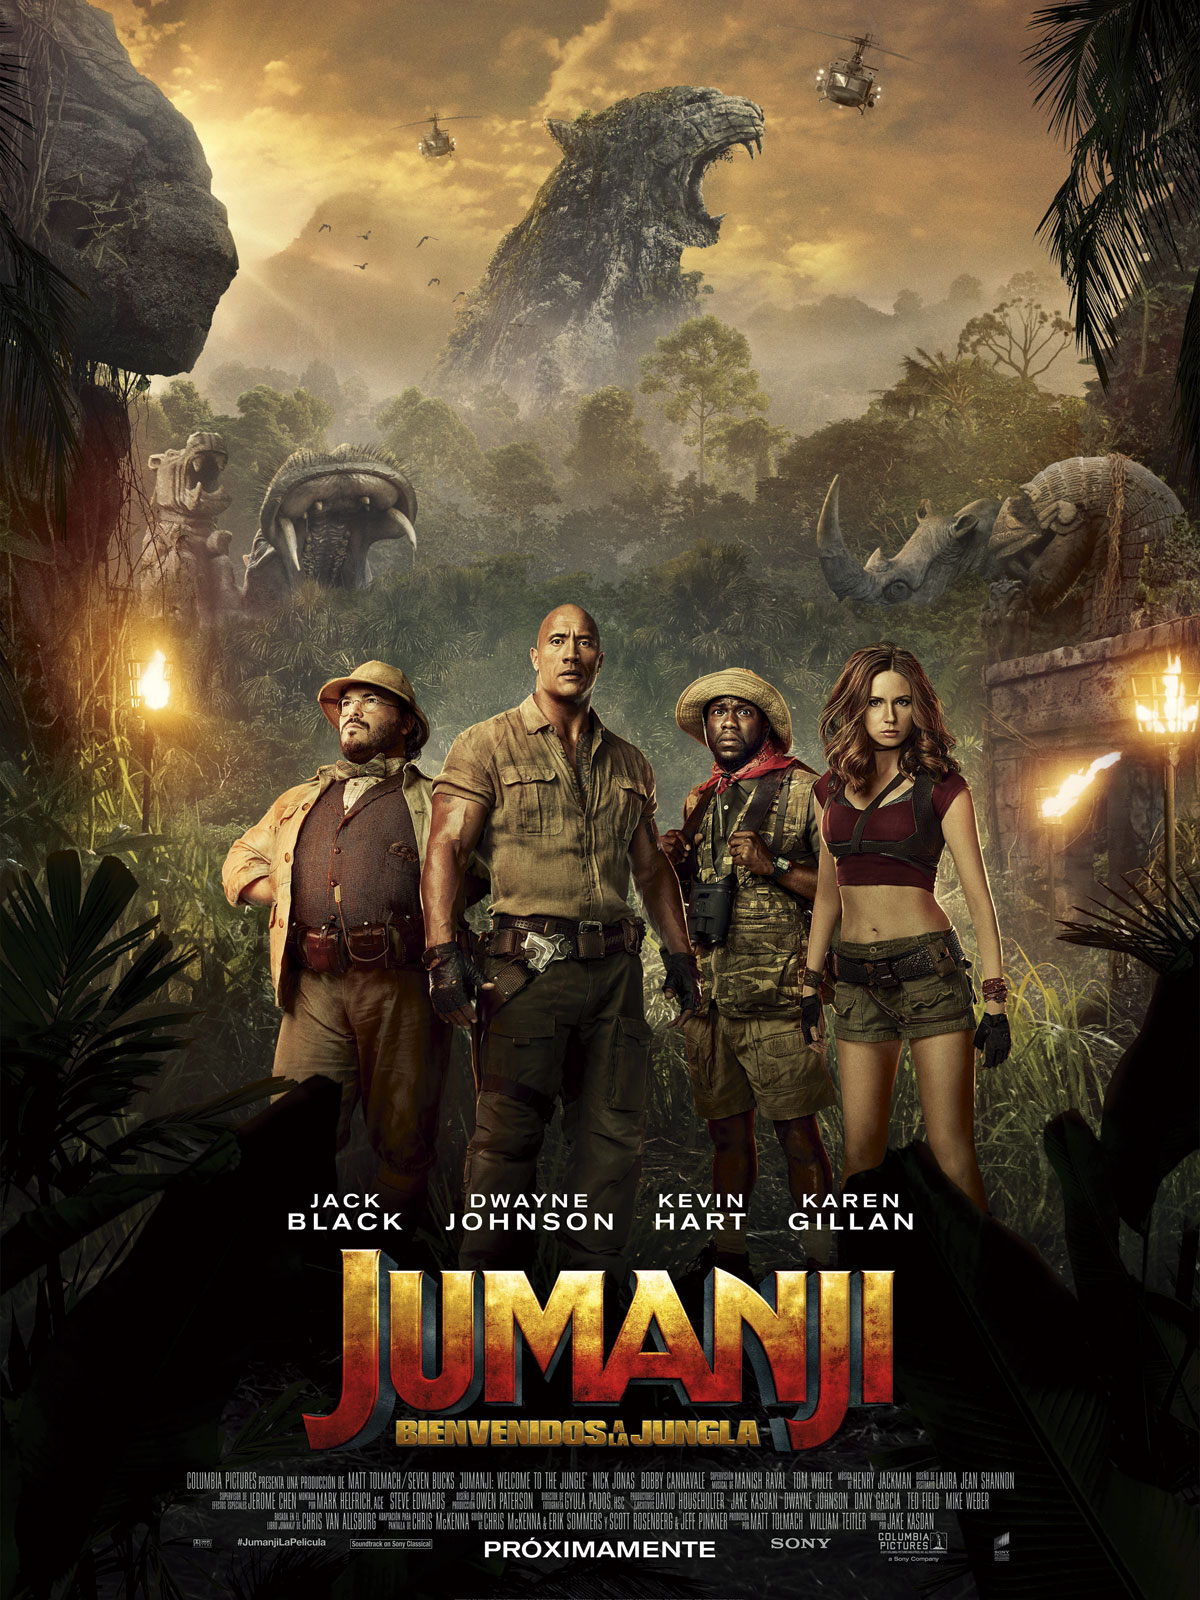

# Ejercicio Jumanji - Bienvenidos a la jungla

Wellcome to Jumanji dear adventurers. Unfortunately not everything are good news, some players have been playing to the game and, as a result of they dumb plays, a stampede of cats and dogs is now running in the real world.

As a fellow explorer I am sure that you understand the urgency of the situation. To solve it, we need to create a computer vision algorithm using CNNs to detect the cats and the dogs.

In order to do so we require the following steps:

- Create an image preprocessing pipeline to treat the images that we are providing. Perform data augmentation over the dataset, at least rotations.

- Test several architechtures (at least 3) and evaluate their performance over the dataset.

- Visualize the feature maps of some of the early and late layers of the models developed. ¿Is there any feature which could be explained through them?

- Finally select the model which performs the best over the whole dataset and explain why.

Fellow adventurer, thanks for your time, Jumanji will not forget your efforts.

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/cats_and_dogs_filtered.zip
!unzip cats_and_dogs_filtered.zip

--2022-01-15 16:45:31--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M  45.1MB/s    in 1.5s    

2022-01-15 16:45:33 (45.1 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Archive:  cats_and_dogs_filtered.zip
replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras import optimizers
from keras import models
from glob import glob
import cv2

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, roc_curve, auc

## Data visualization


In [3]:
fich_cats = glob("./cats_and_dogs_filtered/train/cats/*")
fich_cats[0]

'./cats_and_dogs_filtered/train/cats/cat.976.jpg'

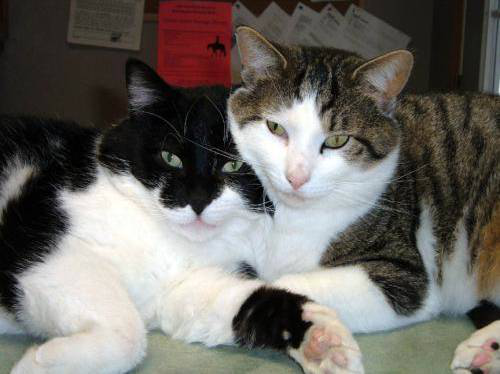

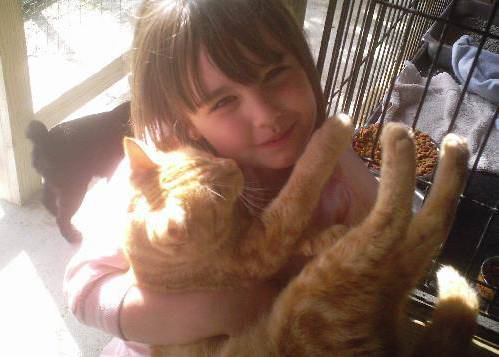

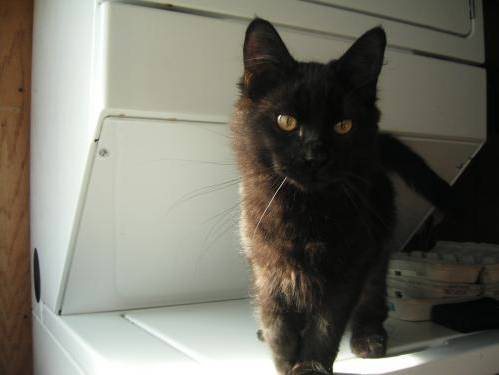

In [4]:
for fich in fich_cats[0:3]:
    imagen = load_img(fich)
    display(imagen)
    print()

In [5]:
fich_dogs = glob("./cats_and_dogs_filtered/train/dogs/*")
fich_dogs[0]

'./cats_and_dogs_filtered/train/dogs/dog.362.jpg'

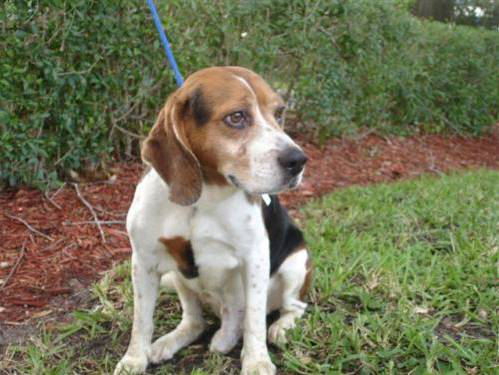

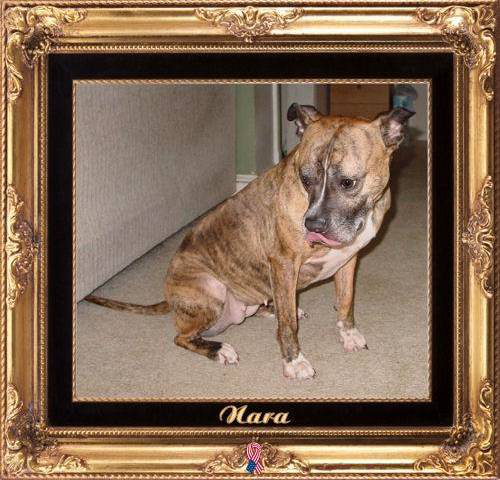

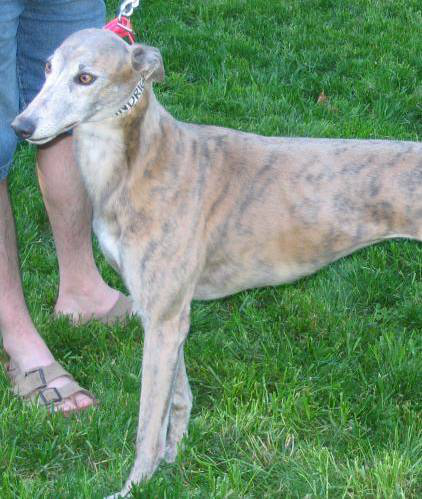

In [6]:
for fich in fich_dogs[0:3]:
    imagen = load_img(fich)
    display(imagen)
    print()

## Data augmentation: rotation.



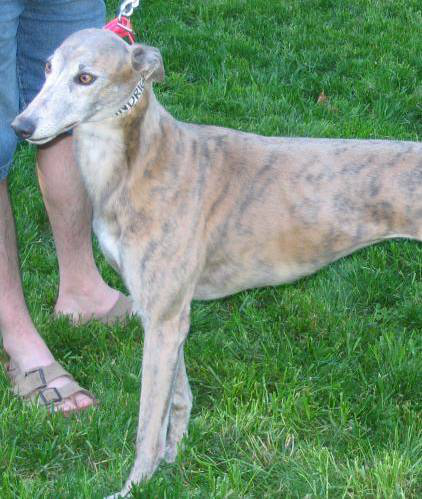

In [7]:
imagen = load_img(fich)
imagen

In [8]:
def preprocess_input(x):
     return x/255.


In [9]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    rotation_range=60)

In [10]:
imagen_num = np.expand_dims(np.array(imagen), axis=0)

In [11]:
imagen_num.shape

(1, 499, 422, 3)

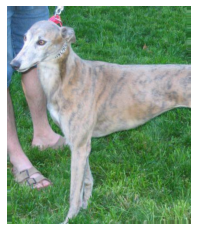

In [12]:
plt.imshow(train_datagen.flow(imagen_num)[0][0])
plt.axis("off");

## Image size


In [13]:
img_width, img_height = 120, 120

normed_dims = (img_height, img_width)

## Architechture 1

In [14]:
model = Sequential()

model.add(Conv2D(8, (3,3), activation='relu', input_shape=normed_dims+(3,)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())

model.add(Dropout(0.3))
model.add(Dense(20, activation='relu', kernel_regularizer="l2")) # regularizador L2
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer="rmsprop", metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0

In [16]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    rotation_range=40)

val_datagen  = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

In [17]:
train_data_dir = ('./cats_and_dogs_filtered/train')

In [18]:
validation_data_dir = ('./cats_and_dogs_filtered/validation')

In [19]:
batch_size = 16

In [20]:
validation_data_dir, normed_dims

('./cats_and_dogs_filtered/validation', (120, 120))

In [21]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [22]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

In [23]:
number_train_samples = train_generator.n
number_val_samples   = validation_generator.n

number_train_samples, number_val_samples

(2000, 1000)

In [24]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [25]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

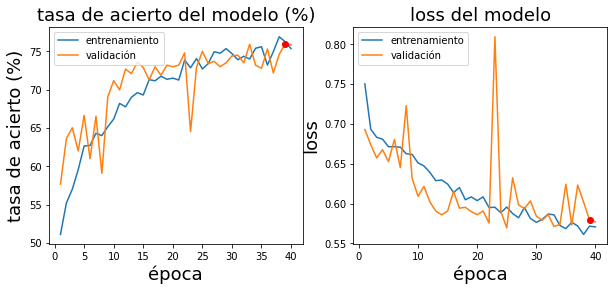

In [26]:
epochs = 40

modelpath="model_current_best.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    history = model.fit(train_generator, 
                        steps_per_epoch=number_train_samples // batch_size,
                        epochs=1,
                        callbacks=callbacks_list,
                        verbose=1,
                        shuffle = False,
                        validation_data=validation_generator,
                        validation_steps=number_val_samples // batch_size
                       )
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [27]:
model = load_model(modelpath)

## Resultados Architechture 1


In [28]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()


125/125 [==============================] - 13s 101ms/step - loss: 0.5026 - accuracy: 0.7950
Train loss    : 0.5025604963302612
Train accuracy: 0.7950000166893005

63/63 [==============================] - 3s 49ms/step - loss: 0.5823 - accuracy: 0.7590
Val loss    : 0.5822585821151733
Val accuracy: 0.7590000033378601



In [29]:
y_real = validation_generator.classes
y_pred_proba = model.predict(validation_generator)
y_pred = np.argmax(y_pred_proba, axis=1)
print('')
print(classification_report(y_real, y_pred))


              precision    recall  f1-score   support

           0       0.74      0.79      0.77       500
           1       0.78      0.72      0.75       500

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000



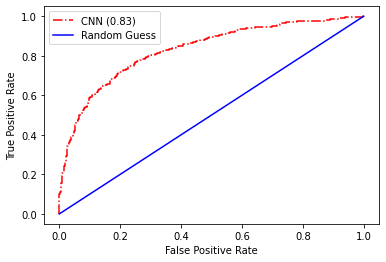

In [30]:
clase_positiva = 1
fpr, tpr, thresholds = roc_curve(y_real==clase_positiva, y_pred_proba[:,clase_positiva])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

test - val

In [31]:
validation_datagen2 = ImageDataGenerator(dtype='float32',
                                   preprocessing_function = preprocess_input)

validation_generator2 = validation_datagen2.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=validation_generator.n, # todas las imágenes del directorio validation
    shuffle=False,
    class_mode='categorical')

Found 1000 images belonging to 2 classes.


In [32]:
validation_generator2.reset()
X_val, y_val = validation_generator2.next()

In [33]:
X_val.shape

(1000, 120, 120, 3)

In [34]:
X_val.max()

1.0

In [35]:
class_indices = validation_generator2.class_indices
class_indices

{'cats': 0, 'dogs': 1}

Probabilidad perro: 29.0%
Probabilidad gato : 71.0%


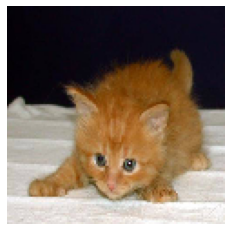

In [36]:
ind_val1 = 84

image = X_val[ind_val1].copy()

plt.imshow(image, cmap='jet')
plt.axis("off")
p = model.predict(np.expand_dims(image, axis=0))[0][class_indices["dogs"]]
print("Probabilidad perro: {:2.1f}%".format(100*p))
p = model.predict(np.expand_dims(image, axis=0))[0][class_indices["cats"]]
print("Probabilidad gato : {:2.1f}%".format(100*p))

## Early layer feature Maps Architechture 1


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 8)       224       
                                                                 
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________





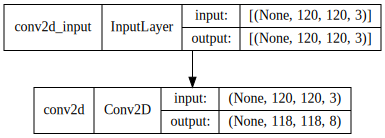

In [37]:
# salida de una sola capa
ncapa = 0
#intermediate_layer_model = Model(inputs=model.input,
#                                 outputs=model.layers[ncapa].output)

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[ncapa].output)

intermediate_layer_model.summary()
print("\n\n")

display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True,dpi=72).create(prog='dot', format='svg')))


In [38]:
imagen = X_val[84]
imagen.shape

(120, 120, 3)

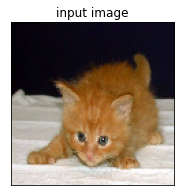

Salidas capa conv2d (1, 118, 118, 8)


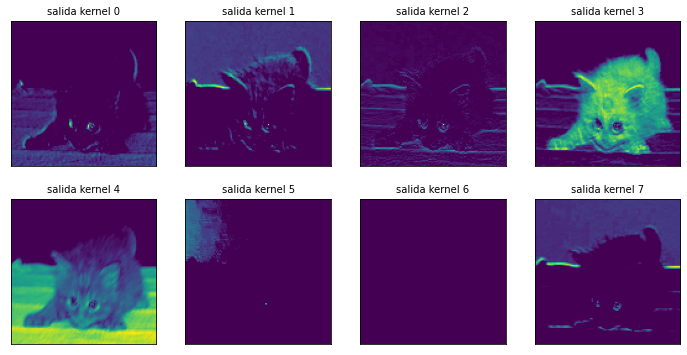

In [39]:
ejemplo = 84

imagen = X_val[ejemplo]
aux = np.expand_dims(imagen, axis=0)
salida_capa = intermediate_layer_model.predict(aux)

plt.figure(figsize=(3,3))
plt.imshow(imagen, cmap='gray')
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

print("Salidas capa "+intermediate_layer_model.layers[-1].name, salida_capa.shape)

nsalidas = salida_capa.shape[-1]
ncols = 4
nrows = int(np.ceil(nsalidas / ncols))

ma = abs(salida_capa).max()

plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

for i in range(nsalidas):
    plt.subplot(nrows,ncols,i+1)
#    plt.imshow(salida_capa[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
    plt.imshow(salida_capa[0,:,:,i], cmap='viridis')
    plt.xticks(())
    plt.yticks(())
    plt.title('salida kernel %d' % i, fontsize=10)

## Late layer feature Maps Architechture 1




Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        4640

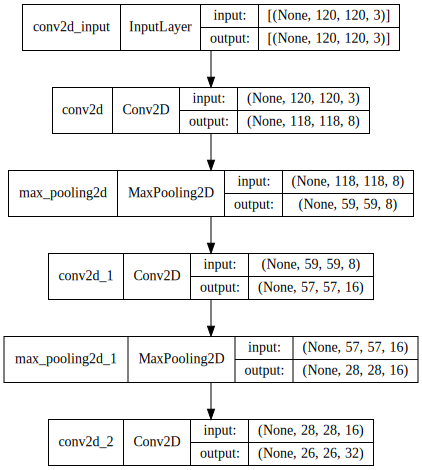

In [40]:
# salida de una sola capa
ncapa = 0

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[ncapa+4].output)

intermediate_layer_model.summary()
print("\n\n")

display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True,dpi=72).create(prog='dot', format='svg')))


In [41]:
imagen = X_val[84]
imagen.shape

(120, 120, 3)

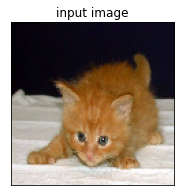

Salidas capa conv2d_2 (1, 26, 26, 32)


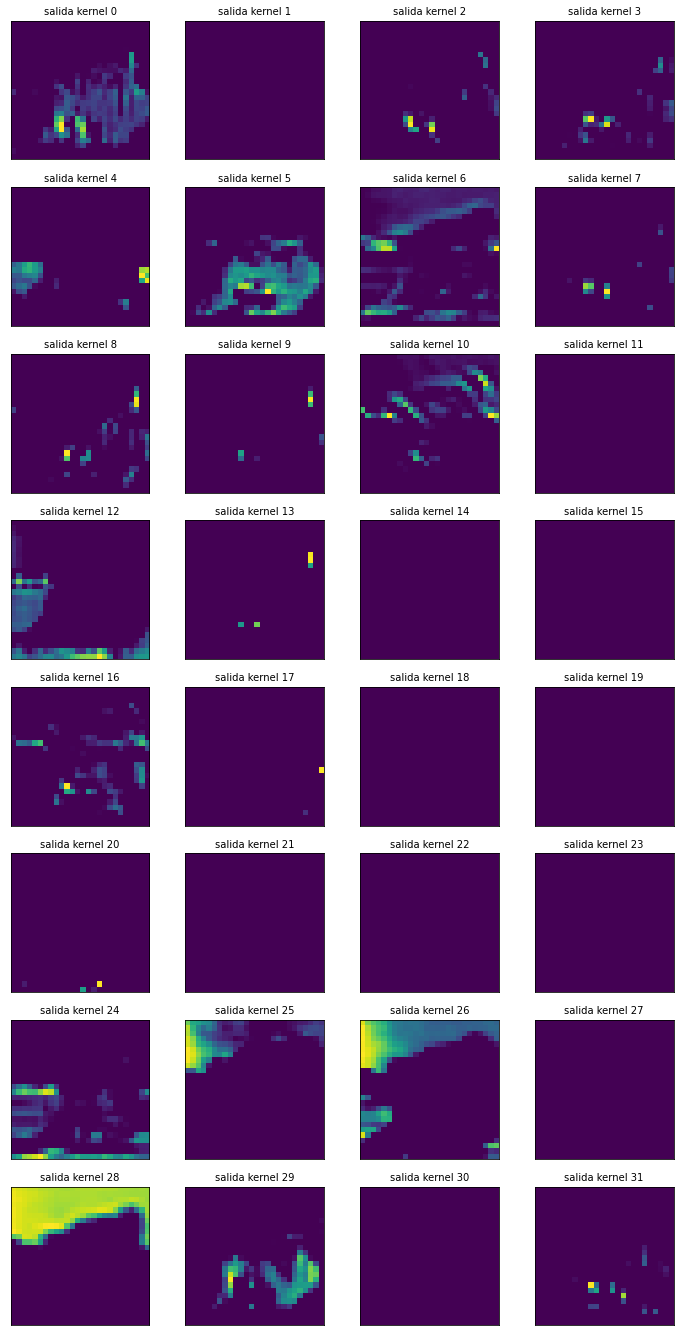

In [42]:
ejemplo = 84

imagen = X_val[ejemplo]
aux = np.expand_dims(imagen, axis=0)
salida_capa = intermediate_layer_model.predict(aux)

plt.figure(figsize=(3,3))
plt.imshow(imagen, cmap='gray')
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

print("Salidas capa "+intermediate_layer_model.layers[-1].name, salida_capa.shape)

nsalidas = salida_capa.shape[-1]
ncols = 4
nrows = int(np.ceil(nsalidas / ncols))

ma = abs(salida_capa).max()

plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

for i in range(nsalidas):
    plt.subplot(nrows,ncols,i+1)
#    plt.imshow(salida_capa[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
    plt.imshow(salida_capa[0,:,:,i], cmap='viridis')
    plt.xticks(())
    plt.yticks(())
    plt.title('salida kernel %d' % i, fontsize=10)

## Architechture 2

In [43]:
model2 = Sequential()

model2.add(Conv2D(32, (5,5), activation='relu', input_shape=normed_dims+(3,)))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(32, (5,5), activation='relu'))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(64, (5,5), activation='relu'))
model2.add(MaxPooling2D((2,2)))
model2.add(Flatten())

model2.add(Dropout(0.5))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(2, activation='softmax'))
model2.compile(loss='categorical_crossentropy',optimizer="rmsprop", metrics=['accuracy'])

In [44]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 116, 116, 32)      2432      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 58, 58, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 54, 54, 32)        25632     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 27, 27, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 23, 23, 64)        51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 11, 11, 64)      

In [45]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    rotation_range=40)

val_datagen  = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

In [46]:
train_data_dir = ('./cats_and_dogs_filtered/train')

In [47]:
validation_data_dir = ('./cats_and_dogs_filtered/validation')

In [48]:
batch_size = 16

In [49]:
validation_data_dir, normed_dims

('./cats_and_dogs_filtered/validation', (120, 120))

In [50]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [51]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

In [52]:
number_train_samples = train_generator.n
number_val_samples   = validation_generator.n

number_train_samples, number_val_samples

(2000, 1000)

In [53]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [54]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

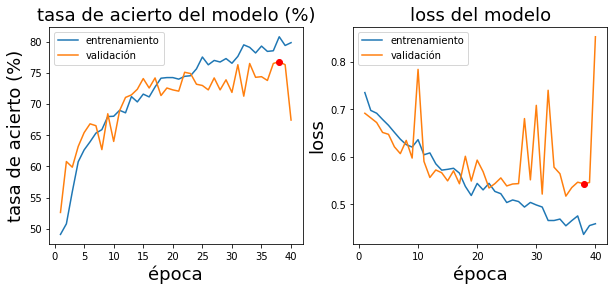

In [55]:
epochs = 40

modelpath="model2_current_best.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    history = model2.fit(train_generator, 
                        steps_per_epoch=number_train_samples // batch_size,
                        epochs=1,
                        callbacks=callbacks_list,
                        verbose=1,
                        shuffle = False,
                        validation_data=validation_generator,
                        validation_steps=number_val_samples // batch_size
                       )
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [56]:
model2 = load_model(modelpath)

## Resultados Arquitechture 2


In [57]:
scores_tr = model2.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model2.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()


125/125 [==============================] - 13s 103ms/step - loss: 0.3714 - accuracy: 0.8335
Train loss    : 0.37140360474586487
Train accuracy: 0.8335000276565552

63/63 [==============================] - 3s 51ms/step - loss: 0.5441 - accuracy: 0.7680
Val loss    : 0.544108510017395
Val accuracy: 0.7680000066757202



In [58]:
y_real = validation_generator.classes
y_pred_proba = model2.predict(validation_generator)
y_pred = np.argmax(y_pred_proba, axis=1)
print('')
print(classification_report(y_real, y_pred))


              precision    recall  f1-score   support

           0       0.75      0.81      0.78       500
           1       0.79      0.73      0.76       500

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.77      0.77      0.77      1000



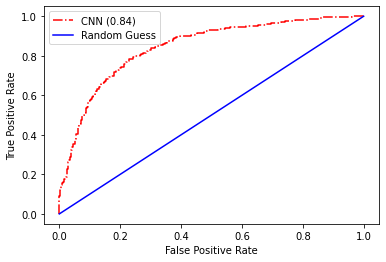

In [59]:
clase_positiva = 1
fpr, tpr, thresholds = roc_curve(y_real==clase_positiva, y_pred_proba[:,clase_positiva])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

test - val

In [60]:
validation_datagen2 = ImageDataGenerator(dtype='float32',
                                   preprocessing_function = preprocess_input)

validation_generator2 = validation_datagen2.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=validation_generator.n, # todas las imágenes del directorio validation
    shuffle=False,
    class_mode='categorical')

Found 1000 images belonging to 2 classes.


In [61]:
validation_generator2.reset()
X_val, y_val = validation_generator2.next()

In [62]:
X_val.shape

(1000, 120, 120, 3)

In [63]:
X_val.max()

1.0

In [64]:
class_indices = validation_generator2.class_indices
class_indices

{'cats': 0, 'dogs': 1}

Probabilidad perro: 86.2%
Probabilidad gato : 13.8%


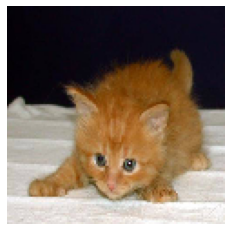

In [65]:
ind_val1 = 84

image = X_val[ind_val1].copy()

plt.imshow(image, cmap='jet')
plt.axis("off")
p = model2.predict(np.expand_dims(image, axis=0))[0][class_indices["dogs"]]
print("Probabilidad perro: {:2.1f}%".format(100*p))
p = model2.predict(np.expand_dims(image, axis=0))[0][class_indices["cats"]]
print("Probabilidad gato : {:2.1f}%".format(100*p))

## Early layer feature Maps Architechture 2


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3_input (InputLayer)  [(None, 120, 120, 3)]    0         
                                                                 
 conv2d_3 (Conv2D)           (None, 116, 116, 32)      2432      
                                                                 
Total params: 2,432
Trainable params: 2,432
Non-trainable params: 0
_________________________________________________________________





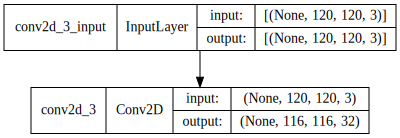

In [66]:
# salida de una sola capa
ncapa = 0
#intermediate_layer_model = Model(inputs=model.input,
#                                 outputs=model.layers[ncapa].output)

intermediate_layer_model = Model(inputs=model2.input,
                                 outputs=model2.layers[ncapa].output)

intermediate_layer_model.summary()
print("\n\n")

display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True,dpi=72).create(prog='dot', format='svg')))


In [67]:
imagen = X_val[84]
imagen.shape

(120, 120, 3)

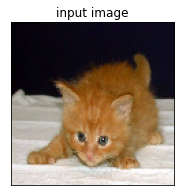

Salidas capa conv2d_3 (1, 116, 116, 32)


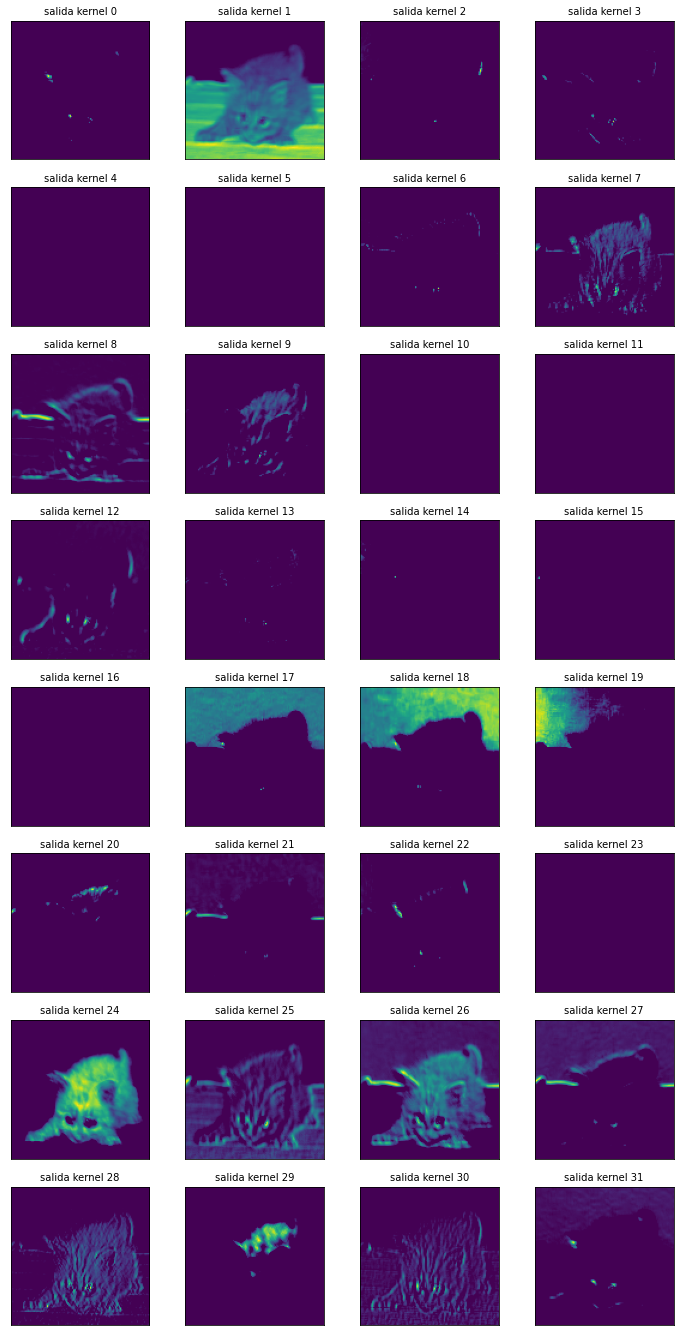

In [68]:
ejemplo = 84

imagen = X_val[ejemplo]
aux = np.expand_dims(imagen, axis=0)
salida_capa = intermediate_layer_model.predict(aux)

plt.figure(figsize=(3,3))
plt.imshow(imagen, cmap='gray')
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

print("Salidas capa "+intermediate_layer_model.layers[-1].name, salida_capa.shape)

nsalidas = salida_capa.shape[-1]
ncols = 4
nrows = int(np.ceil(nsalidas / ncols))

ma = abs(salida_capa).max()

plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

for i in range(nsalidas):
    plt.subplot(nrows,ncols,i+1)
#    plt.imshow(salida_capa[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
    plt.imshow(salida_capa[0,:,:,i], cmap='viridis')
    plt.xticks(())
    plt.yticks(())
    plt.title('salida kernel %d' % i, fontsize=10)

## Late layer feature Maps Architechture 2



Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3_input (InputLayer)  [(None, 120, 120, 3)]    0         
                                                                 
 conv2d_3 (Conv2D)           (None, 116, 116, 32)      2432      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 58, 58, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 54, 54, 32)        25632     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 27, 27, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 23, 23, 64)        5126

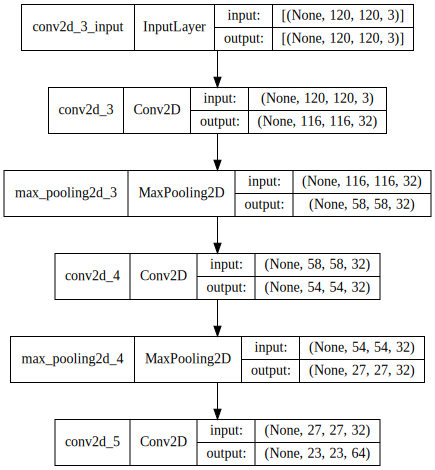

In [69]:
# salida de una sola capa
ncapa = 0

intermediate_layer_model = Model(inputs=model2.input,
                                 outputs=model2.layers[ncapa+4].output)

intermediate_layer_model.summary()
print("\n\n")

display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True,dpi=72).create(prog='dot', format='svg')))


In [70]:
imagen = X_val[84]
imagen.shape

(120, 120, 3)

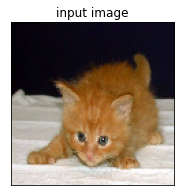

Salidas capa conv2d_5 (1, 23, 23, 64)


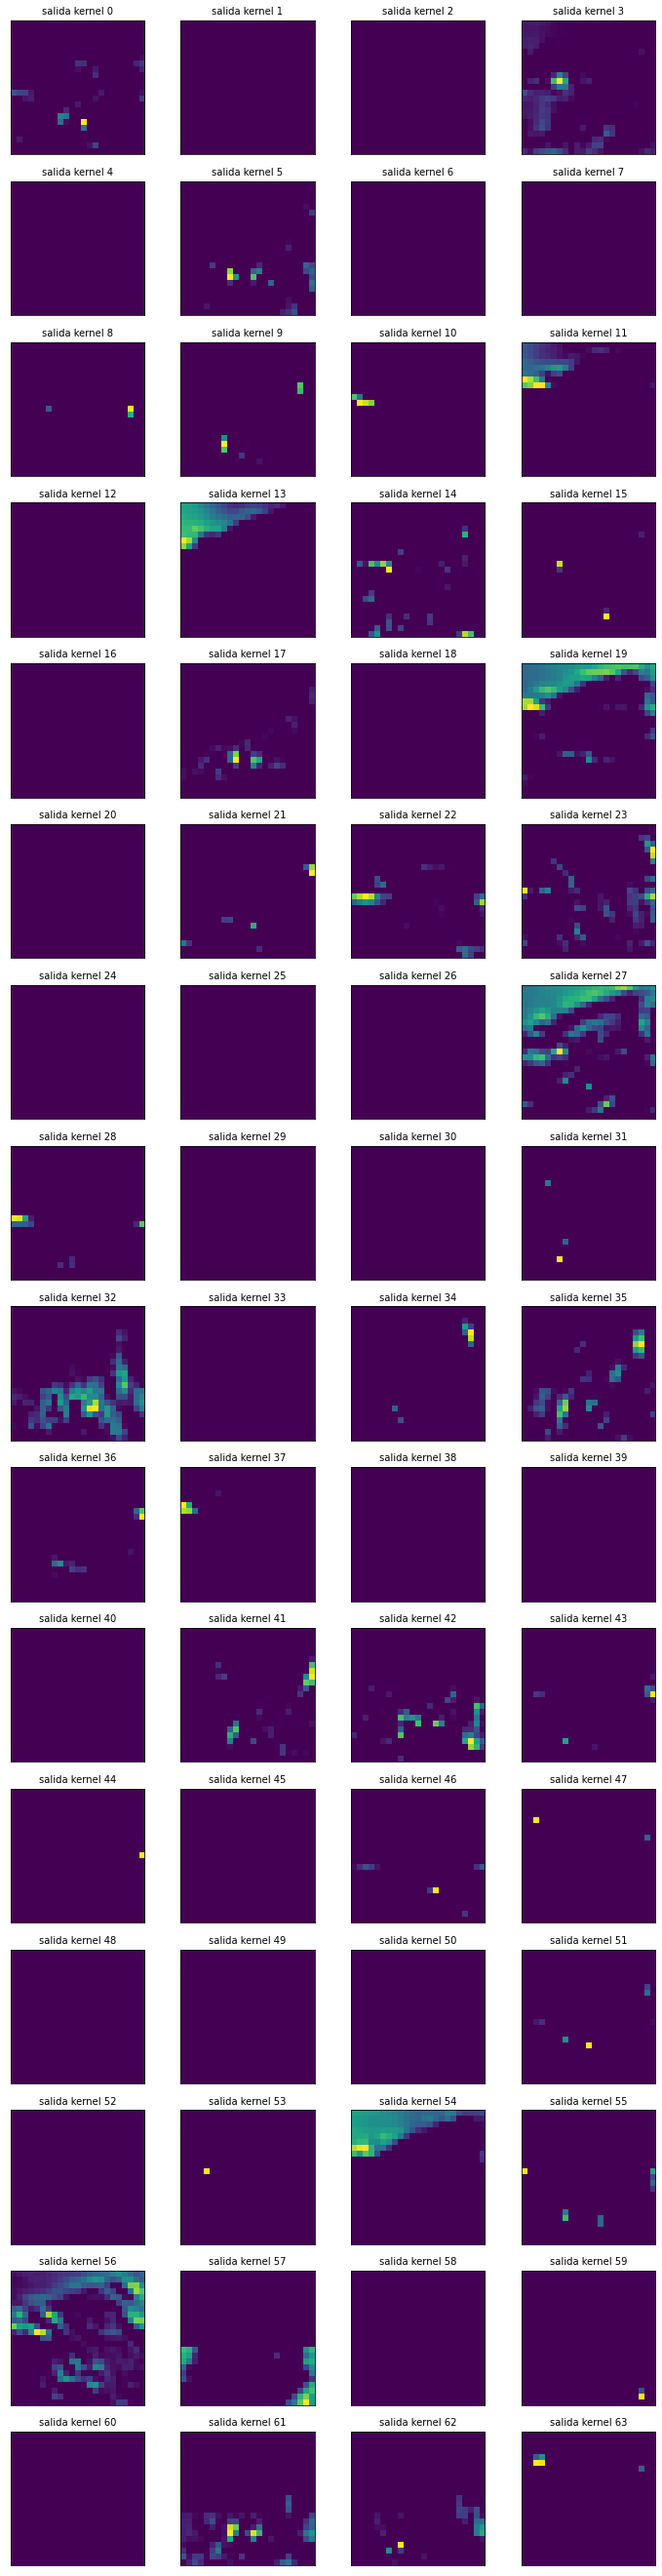

In [71]:
ejemplo = 84

imagen = X_val[ejemplo]
aux = np.expand_dims(imagen, axis=0)
salida_capa = intermediate_layer_model.predict(aux)

plt.figure(figsize=(3,3))
plt.imshow(imagen, cmap='gray')
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

print("Salidas capa "+intermediate_layer_model.layers[-1].name, salida_capa.shape)

nsalidas = salida_capa.shape[-1]
ncols = 4
nrows = int(np.ceil(nsalidas / ncols))

ma = abs(salida_capa).max()

plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

for i in range(nsalidas):
    plt.subplot(nrows,ncols,i+1)
#    plt.imshow(salida_capa[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
    plt.imshow(salida_capa[0,:,:,i], cmap='viridis')
    plt.xticks(())
    plt.yticks(())
    plt.title('salida kernel %d' % i, fontsize=10)

## Architechture 3

In [72]:
model3 = Sequential()

model3.add(Conv2D(32, (3,3), activation='relu', input_shape=normed_dims+(3,)))
model3.add(MaxPooling2D((2,2)))
model3.add(Conv2D(64, (3,3), activation='relu'))
model3.add(MaxPooling2D((2,2)))
model3.add(Conv2D(128, (3,3), activation='relu'))
model3.add(MaxPooling2D((2,2)))
model3.add(Flatten())
model3.add(Dropout(0.5))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(2, activation='softmax'))
model3.compile(loss='categorical_crossentropy',optimizer="rmsprop", metrics=['accuracy'])

In [73]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 26, 26, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 128)     

In [74]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    rotation_range=40)

val_datagen  = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

In [75]:
train_data_dir = ('./cats_and_dogs_filtered/train')

In [76]:
validation_data_dir = ('./cats_and_dogs_filtered/validation')

In [77]:
batch_size = 16

In [78]:
validation_data_dir, normed_dims

('./cats_and_dogs_filtered/validation', (120, 120))

In [79]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [80]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

In [81]:
number_train_samples = train_generator.n
number_val_samples   = validation_generator.n

number_train_samples, number_val_samples

(2000, 1000)

In [82]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [83]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

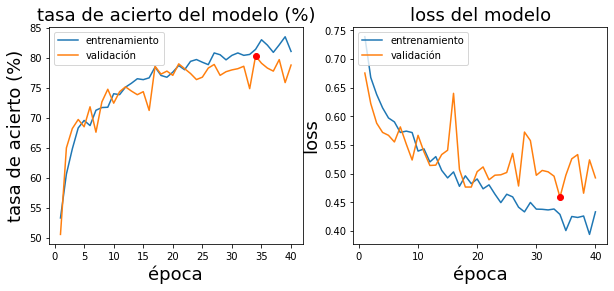

In [84]:
epochs = 40

modelpath="model3_current_best.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    history = model3.fit(train_generator, 
                        steps_per_epoch=number_train_samples // batch_size,
                        epochs=1,
                        callbacks=callbacks_list,
                        verbose=1,
                        shuffle = False,
                        validation_data=validation_generator,
                        validation_steps=number_val_samples // batch_size
                       )
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [85]:
model3 = load_model(modelpath)

## Resultados Architechture 3


In [86]:
scores_tr = model3.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model3.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()


125/125 [==============================] - 13s 101ms/step - loss: 0.3209 - accuracy: 0.8700
Train loss    : 0.3208746314048767
Train accuracy: 0.8700000047683716

63/63 [==============================] - 3s 51ms/step - loss: 0.4579 - accuracy: 0.8040
Val loss    : 0.45790746808052063
Val accuracy: 0.8040000200271606



In [87]:
y_real = validation_generator.classes
y_pred_proba = model3.predict(validation_generator)
y_pred = np.argmax(y_pred_proba, axis=1)
print('')
print(classification_report(y_real, y_pred))


              precision    recall  f1-score   support

           0       0.79      0.83      0.81       500
           1       0.82      0.78      0.80       500

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000



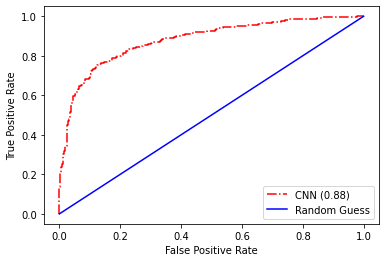

In [88]:
clase_positiva = 1
fpr, tpr, thresholds = roc_curve(y_real==clase_positiva, y_pred_proba[:,clase_positiva])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

test - val

In [89]:
validation_datagen2 = ImageDataGenerator(dtype='float32',
                                   preprocessing_function = preprocess_input)

validation_generator2 = validation_datagen2.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=validation_generator.n, # todas las imágenes del directorio validation
    shuffle=False,
    class_mode='categorical')

Found 1000 images belonging to 2 classes.


In [90]:
validation_generator2.reset()
X_val, y_val = validation_generator2.next()

In [91]:
X_val.shape

(1000, 120, 120, 3)

In [92]:
X_val.max()

1.0

In [93]:
class_indices = validation_generator2.class_indices
class_indices

{'cats': 0, 'dogs': 1}

Probabilidad perro: 35.2%
Probabilidad gato : 64.8%


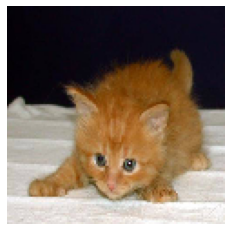

In [94]:
ind_val1 = 84

image = X_val[ind_val1].copy()

plt.imshow(image, cmap='jet')
plt.axis("off")
p = model3.predict(np.expand_dims(image, axis=0))[0][class_indices["dogs"]]
print("Probabilidad perro: {:2.1f}%".format(100*p))
p = model3.predict(np.expand_dims(image, axis=0))[0][class_indices["cats"]]
print("Probabilidad gato : {:2.1f}%".format(100*p))

## Early layer feature Maps Architechture 3


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6_input (InputLayer)  [(None, 120, 120, 3)]    0         
                                                                 
 conv2d_6 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________





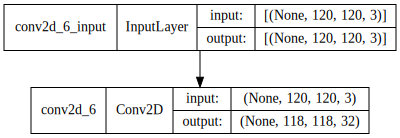

In [95]:
# salida de una sola capa
ncapa = 0
#intermediate_layer_model = Model(inputs=model.input,
#                                 outputs=model.layers[ncapa].output)

intermediate_layer_model = Model(inputs=model3.input,
                                 outputs=model3.layers[ncapa].output)

intermediate_layer_model.summary()
print("\n\n")

display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True,dpi=72).create(prog='dot', format='svg')))


In [96]:
imagen = X_val[84]
imagen.shape

(120, 120, 3)

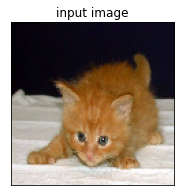

Salidas capa conv2d_6 (1, 118, 118, 32)


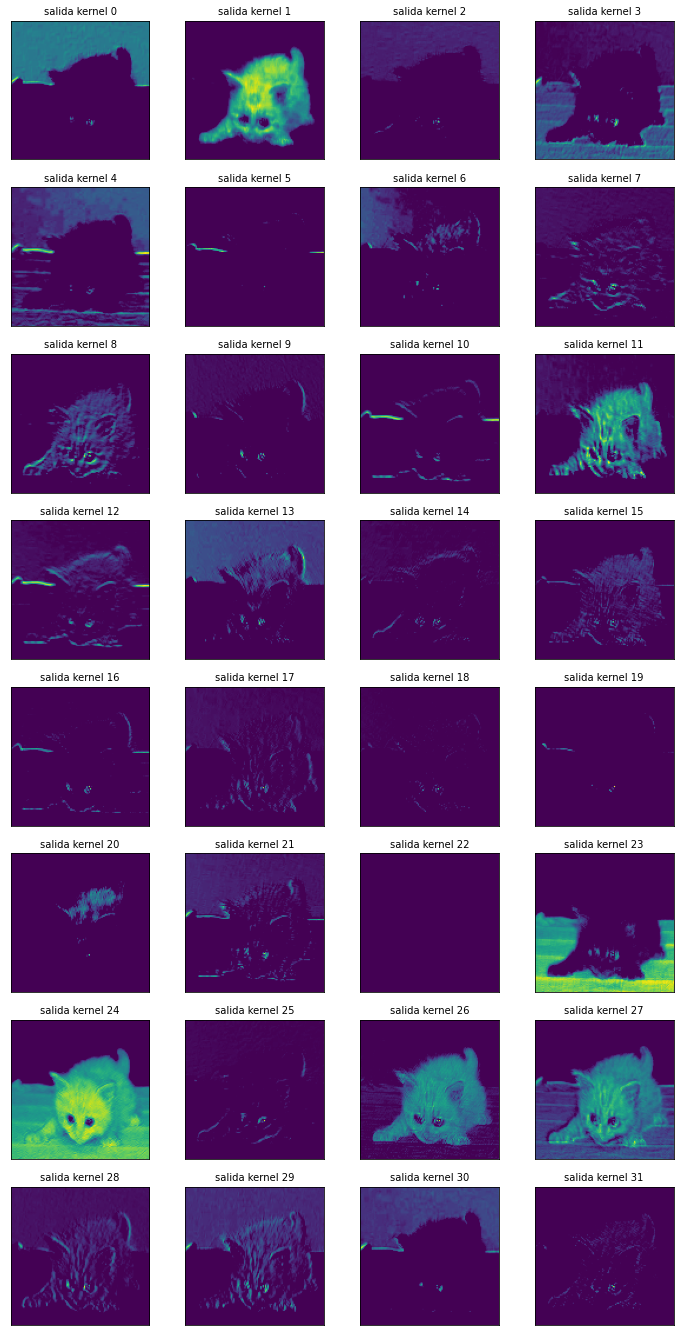

In [97]:
ejemplo = 84

imagen = X_val[ejemplo]
aux = np.expand_dims(imagen, axis=0)
salida_capa = intermediate_layer_model.predict(aux)

plt.figure(figsize=(3,3))
plt.imshow(imagen, cmap='gray')
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

print("Salidas capa "+intermediate_layer_model.layers[-1].name, salida_capa.shape)

nsalidas = salida_capa.shape[-1]
ncols = 4
nrows = int(np.ceil(nsalidas / ncols))

ma = abs(salida_capa).max()

plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

for i in range(nsalidas):
    plt.subplot(nrows,ncols,i+1)
#    plt.imshow(salida_capa[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
    plt.imshow(salida_capa[0,:,:,i], cmap='viridis')
    plt.xticks(())
    plt.yticks(())
    plt.title('salida kernel %d' % i, fontsize=10)

## Late layer feature Maps Architechture 3



Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6_input (InputLayer)  [(None, 120, 120, 3)]    0         
                                                                 
 conv2d_6 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 26, 26, 128)       7385

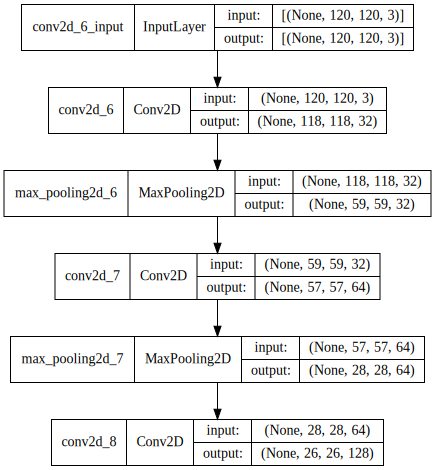

In [98]:
# salida de una sola capa
ncapa = 0

intermediate_layer_model = Model(inputs=model3.input,
                                 outputs=model3.layers[ncapa+4].output)

intermediate_layer_model.summary()
print("\n\n")

display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True,dpi=72).create(prog='dot', format='svg')))


In [99]:
imagen = X_val[84]
imagen.shape

(120, 120, 3)

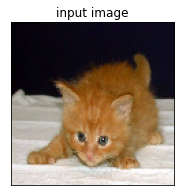

Salidas capa conv2d_8 (1, 26, 26, 128)


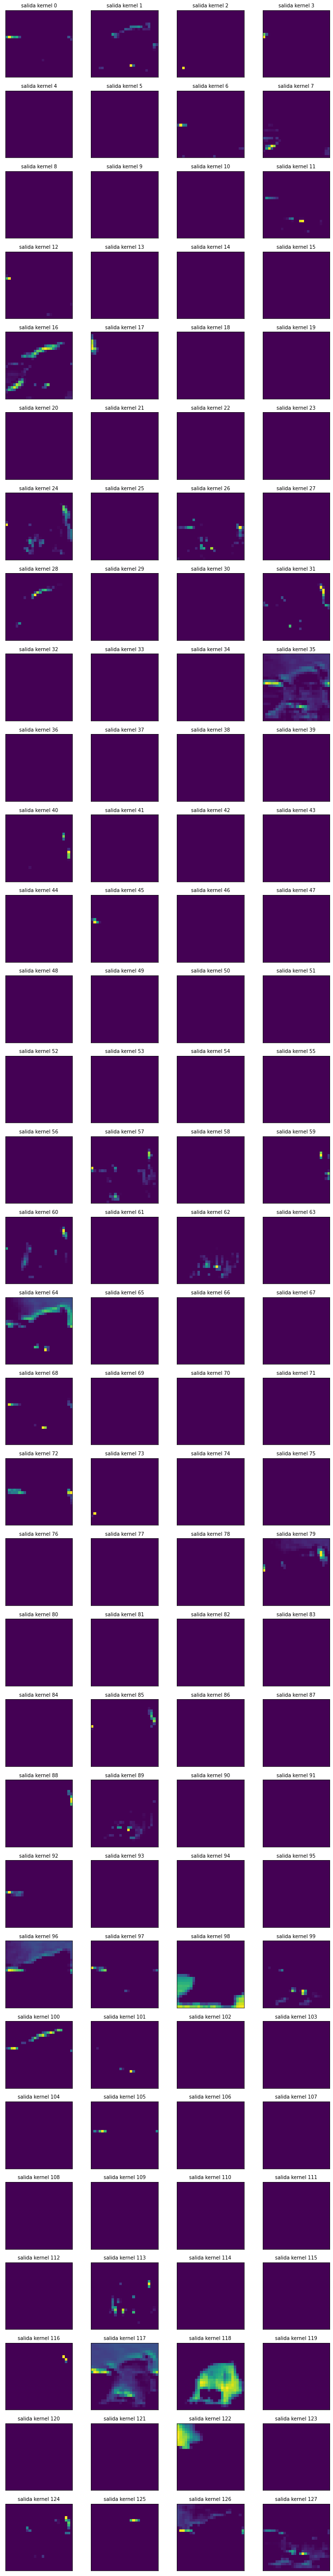

In [100]:
ejemplo = 84

imagen = X_val[ejemplo]
aux = np.expand_dims(imagen, axis=0)
salida_capa = intermediate_layer_model.predict(aux)

plt.figure(figsize=(3,3))
plt.imshow(imagen, cmap='gray')
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

print("Salidas capa "+intermediate_layer_model.layers[-1].name, salida_capa.shape)

nsalidas = salida_capa.shape[-1]
ncols = 4
nrows = int(np.ceil(nsalidas / ncols))

ma = abs(salida_capa).max()

plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

for i in range(nsalidas):
    plt.subplot(nrows,ncols,i+1)
#    plt.imshow(salida_capa[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
    plt.imshow(salida_capa[0,:,:,i], cmap='viridis')
    plt.xticks(())
    plt.yticks(())
    plt.title('salida kernel %d' % i, fontsize=10)

## Conclusions

For this case of stuty the strategy we've taken has been incrementing the number of filters of the different convolutional layers and also test two kernel sizes (3,3) and (5,5).

Respecting the data augmentation we've chosen to use only rotations because of the increment of time in training tasks.

After testing 3 kind of architechtures we can conclude that the best model is the third one, because it has around an 80% accuracy in both validation and training sets, also the ROC curve is the best one.

About the feature maps, in the early layers ones it seems that the eyes, the kind of hair and the shape of the animals are highlighted but we couldn't extract any information from the late feature maps.